# Analiza Danych (SAD) - Projekt Społeczny

Dokumentacja i analiza statystyczna dla przedmiotu **Statystyczna Analiza Danych** (SAD).

Celem tego notebooka jest przeprowadzenie formalnej analizy statystycznej zgromadzonego korpusu danych. W odróżnieniu od analizy eksploracyjnej (AED), skupiamy się tutaj na weryfikacji hipotez, estymacji parametrów populacji oraz modelowaniu zależności.

**Zakres analizy:**
1.  **Statystyka opisowa**: Miary położenia, zmienności i asymetrii.
2.  **Rozkłady teoretyczne**: Badanie zgodności z rozkładem normalnym (testy KS, Shapiro-Wilka).
3.  **Estymacja przedziałowa**: Wyznaczanie przedziałów ufności dla średniej i wariancji.
4.  **Weryfikacja hipotez**: Testy parametryczne i nieparametryczne (t-Studenta, ANOVA, Chi-kwadrat).
5.  **Regresja**: Modelowanie zależności liniowej między zmiennymi.


## 0. Przygotowanie Środowiska i Danych

In [23]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

### Wczytanie i Transformacja Danych
Ponieważ oryginalny zbiór danych zawiera głównie tekst, na potrzeby analizy statystycznej (wymagającej zmiennych ilościowych/ciągłych) dokonujemy inżynierii cech (`Feature Engineering`).

- **Zmienna zależna (Y)**: Długość posta (`char_count`) - pozwala badać "zaangażowanie" lub "wylewność" autora.
- **Zmienne niezależne (X)**: Kategoria (`category`), Sentyment (`sentiment`) - czynniki grupujące.


In [24]:
# Wczytanie danych z korpus.json
try:
    with open('korpus.json', 'r', encoding='utf-8') as f:
        korpus = json.load(f)
    df = pd.DataFrame(korpus)
    print(f"Wczytano {len(df)} rekordów.")
except FileNotFoundError:
    print("Błąd: Nie znaleziono pliku korpus.json. Upewnij się, że jesteś w dobrym katalogu.")

# Inżynieria cech (Feature Engineering)
# 1. Długość tekstu (liczba znaków)
df['char_count'] = df['tekst'].apply(len)

# 2. Liczba słów
df['word_count'] = df['tekst'].apply(lambda x: len(x.split()))

# 3. Mapowanie sentymentu na wartości liczbowe (dla korelacji/regresji)
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_val'] = df['sentiment'].map(sentiment_map)

df[['tekst', 'kategoria', 'sentiment', 'char_count', 'word_count']].head()

Wczytano 188 rekordów.


,tekst,kategoria,sentiment,char_count,word_count
0,Czy politechnika popiera wykorzystywanie koni ...,Pytania Krytyczne,negative,119,17
1,Ostatnie 365 dni to dla nas nie tylko liczby i...,Komunikaty Uczelni,positive,117,19
2,Kiedy będzie dzień otwarty dla kandydatów na s...,Pytania Rekrutacyjne,neutral,52,8
3,Czy są dostępne programy mentoringowe?,Pytania Organizacyjne,neutral,38,5
4,Jak wygląda proces rejestracji na przedmioty?,Pytania Organizacyjne,neutral,45,6


## 1. Statystyka Opisowa

W tej sekcji badamy podstawowe właściwości rozkładu zmiennej losowej (długości postów).

**Kluczowe pojęcia:**
- **Miary położenia**: Średnia arytmetyczna (gdzie jest "środek" danych?), Mediana (wartość środkowa).
- **Miary zmienności**: Odchylenie standardowe (jak bardzo dane są rozproszone wokół średniej?), Współczynnik zmienności $V = \frac{\sigma}{\bar{x}}$ (zmienność względna).
- **Miary asymetrii (Skośność/Skewness)**:
    - Sk > 0: Asymetria prawostronna (ogon rozkładu ciągnie się w prawo, większość danych po lewej).
    - Sk < 0: Asymetria lewostronna.
    - Sk ≈ 0: Rozkład symetryczny (np. normalny).
- **Kurtoza (Kurtosis)**: Miara "spłaszczenia" rozkładu.
    - K > 0 (Leptokurtyczny): Rozkład wysmukły, grube ogony (dużo wartości skrajnych).
    - K < 0 (Platykurtyczny): Rozkład spłaszczony.


=== Statystyki opisowe dla długości tekstu (znaki) ===
count    188.00000
mean      54.06383
std       24.01083
min       13.00000
25%       40.00000
50%       48.00000
75%       61.25000
max      161.00000
Name: char_count, dtype: float64

Skośność (Skewness): 1.6320
 -> Asymetria prawostronna (dominują krótkie posty, ale są nieliczne bardzo długie)
Kurtoza (Kurtosis): 3.2761
Współczynnik zmienności (V): 44.41%


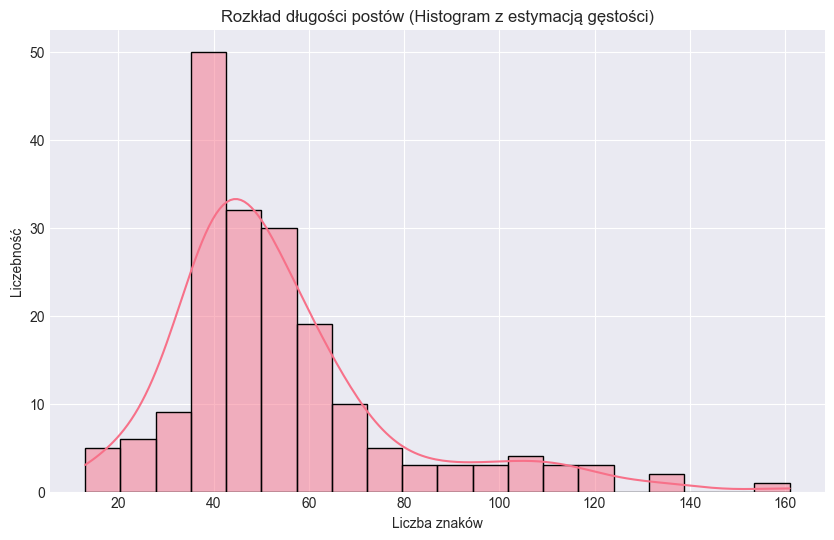

In [25]:
desc_stats = df['char_count'].describe()
skewness = df['char_count'].skew()
kurtosis = df['char_count'].kurt()
cv = df['char_count'].std() / df['char_count'].mean() * 100 # Współczynnik zmienności

print("=== Statystyki opisowe dla długości tekstu (znaki) ===")
print(desc_stats)
print(f"\nSkośność (Skewness): {skewness:.4f}")
if skewness > 0:
    print(" -> Asymetria prawostronna (dominują krótkie posty, ale są nieliczne bardzo długie)")
else:
    print(" -> Asymetria lewostronna")

print(f"Kurtoza (Kurtosis): {kurtosis:.4f}")
print(f"Współczynnik zmienności (V): {cv:.2f}%")

# Histogram (Szereg rozdzielczy przedziałowy)
plt.figure(figsize=(10, 6))
sns.histplot(df['char_count'], bins=20, kde=True)
plt.title('Rozkład długości postów (Histogram z estymacją gęstości)')
plt.xlabel('Liczba znaków')
plt.ylabel('Liczebność')
plt.show()

## 2. Rozkłady Teoretyczne i Testy Zgodności

Sprawdzamy, czy empiryczny rozkład danych (to co widzimy w próbce) pasuje do teoretycznego rozkładu Normalnego (Krzywej Gaussa). Jest to kluczowe założenie wielu testów statystycznych (np. t-Studenta, ANOVA).

### Testy Zgodności (Goodness of Fit)
Stawiamy hipotezy:
- $H_0$: Rozkład badanej cechy **JEST** zgodny z rozkładem normalnym.
- $H_1$: Rozkład badanej cechy **NIE JEST** zgodny z rozkładem normalnym.

**Interpretacja p-value (dla poziomu istotności $\alpha = 0.05$):**
- $p < 0.05$: Odrzucamy $H_0$. Rozkład **nie jest normalny**.
- $p \ge 0.05$: Brak podstaw do odrzucenia $H_0$. Przyjmujemy, że rozkład jest zbliżony do normalnego.


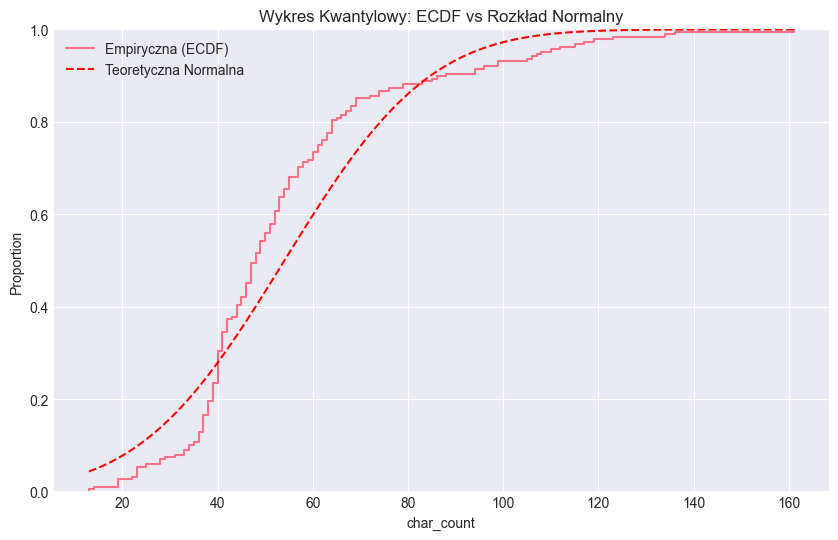

=== Testy Normalności Rozkładu ===
Test Kołmogorowa-Smirnowa: p-value = 5.9023e-05
Test Shapiro-Wilka:       p-value = 2.3352e-12

WNIOSEK: Odrzucamy hipotezę H0. Rozkład nie jest normalny. (Zalecane testy nieparametryczne, ale dla dużych prób (n>30) t-Student jest odporny).


In [26]:
# Wizualizacja: ECDF vs Teoretyczna Normalna
plt.figure(figsize=(10, 6))

# Dystrybuanta Empiryczna
sns.ecdfplot(data=df, x='char_count', label='Empiryczna (ECDF)')

# Teoretyczna Normalna
mu, std = stats.norm.fit(df['char_count'])
x = np.linspace(df['char_count'].min(), df['char_count'].max(), 100)
cdf_theoretical = stats.norm.cdf(x, mu, std)
plt.plot(x, cdf_theoretical, 'r--', label=f'Teoretyczna Normalna')

plt.title('Wykres Kwantylowy: ECDF vs Rozkład Normalny')
plt.legend()
plt.show()

# Testy statystyczne
print("=== Testy Normalności Rozkładu ===")
# 1. Test Kołmogorowa-Smirnowa (KS)
ks_stat, ks_p = stats.kstest(df['char_count'], 'norm', args=(mu, std))
print(f"Test Kołmogorowa-Smirnowa: p-value = {ks_p:.4e}")

# 2. Test Shapiro-Wilka (Większa moc dla mniejszych prób)
shapiro_stat, shapiro_p = stats.shapiro(df['char_count'])
print(f"Test Shapiro-Wilka:       p-value = {shapiro_p:.4e}")

if shapiro_p < 0.05:
    print("\nWNIOSEK: Odrzucamy hipotezę H0. Rozkład nie jest normalny. (Zalecane testy nieparametryczne, ale dla dużych prób (n>30) t-Student jest odporny).")
else:
    print("\nWNIOSEK: Brak podstaw do odrzucenia H0. Rozkład normalny.")

## 3. Estymacja Przedziałowa

Zamiast podawać jedną liczbę (estymator punktowy, np. średnia = 50), podajemy przedział, który z określonym prawdopodobieństwem (np. 95%) pokrywa nieznaną prawdziwą wartość parametru w populacji.

- **Przedział ufności (Confidence Interval - CI) dla średniej**: $[\bar{x} - E, \bar{x} + E]$. Mówi nam: "Gdybyśmy powtarzali badanie 100 razy, w 95 przypadkach średnia wpadłaby do tego worka".
- **Przedział ufności dla wariancji**: Oparty na rozkładzie Chi-kwadrat.


In [27]:
confidence_level = 0.95
alpha = 1 - confidence_level
n = len(df)

# 1. CI dla Średniej (t-Student)
sample_mean = np.mean(df['char_count'])
sample_sem = stats.sem(df['char_count']) # Standard Error of Mean
ci_mean = stats.t.interval(confidence_level, df=n-1, loc=sample_mean, scale=sample_sem)

# 2. CI dla Wariancji (Chi-kwadrat)
sample_var = np.var(df['char_count'], ddof=1)
chi2_lower = stats.chi2.ppf(alpha / 2, df=n-1)
chi2_upper = stats.chi2.ppf(1 - alpha / 2, df=n-1)

ci_var_lower = (n - 1) * sample_var / chi2_upper
ci_var_upper = (n - 1) * sample_var / chi2_lower

print(f"Średnia długość posta: {sample_mean:.2f}")
print(f" >> 95% Przedział ufności dla średniej: ({ci_mean[0]:.2f}, {ci_mean[1]:.2f})")

print(f"\nWariancja: {sample_var:.2f}")
print(f" >> 95% Przedział ufności dla wariancji: ({ci_var_lower:.2f}, {ci_var_upper:.2f})")

Średnia długość posta: 54.06
 >> 95% Przedział ufności dla średniej: (50.61, 57.52)

Wariancja: 576.52
 >> 95% Przedział ufności dla wariancji: (475.43, 713.85)


## 4. Weryfikacja Hipotez Statystycznych

Sprawdzamy, czy różnice , które widzimy w danych, są istotne statystycznie, czy są dziełem przypadku.

### 4.1 Test t-Studenta (dla dwóch grup)
Porównujemy średnią długość postów z sentymentem **Positive** vs **Negative**.
- $H_0$: Średnie w obu grupach są równe ($\mu_1 = \mu_2$).
- $H_1$: Średnie są różne ($\mu_1 \neq \mu_2$).


In [28]:
group_pos = df[df['sentiment'] == 'positive']['char_count']
group_neg = df[df['sentiment'] == 'negative']['char_count']

# Test t-Studenta dla prób niezależnych (Welcha - nie zakładamy równych wariancji)
t_stat, p_val = stats.ttest_ind(group_pos, group_neg, equal_var=False)

print(f"Średnia (Positive): {group_pos.mean():.2f} (n={len(group_pos)})")
print(f"Średnia (Negative): {group_neg.mean():.2f} (n={len(group_neg)})")
print(f"\nWynik testu t-Studenta: t={t_stat:.4f}, p-value={p_val:.4f}")

if p_val < 0.05:
    print("WNIOSEK: Odrzucamy H0. Różnica jest ISTOTNA statystycznie.")
else:
    print("WNIOSEK: Brak podstaw do odrzucenia H0. Różnica jest przypadkowa.")

Średnia (Positive): 56.82 (n=60)
Średnia (Negative): 59.96 (n=57)

Wynik testu t-Studenta: t=-0.6322, p-value=0.5287
WNIOSEK: Brak podstaw do odrzucenia H0. Różnica jest przypadkowa.


### 4.2 Analiza Wariancji (ANOVA)
Rozszerzenie testu t na więcej niż dwie grupy. Sprawdzamy czy **Kategoria** wpływa na **Długość Posta**.
- $H_0$: Średnie we wszystkich kategoriach są takie same.
- $H_1$: Przynajmniej jedna średnia różni się od pozostałych.


Wynik ANOVA (Sentyment vs Długość): F=5.4344, p-value=0.0051
WNIOSEK: Sentyment RÓŻNICUJE długość postów w sposób istotny statystycznie.


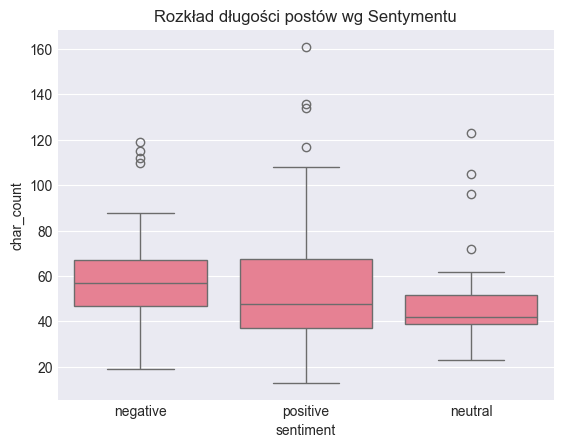

In [29]:
# Przygotowanie grup dla ANOVA
groups = [df[df['sentiment'] == s]['char_count'] for s in df['sentiment'].unique()]

f_stat, p_val_anova = stats.f_oneway(*groups)

print(f"Wynik ANOVA (Sentyment vs Długość): F={f_stat:.4f}, p-value={p_val_anova:.4f}")

if p_val_anova < 0.05:
    print("WNIOSEK: Sentyment RÓŻNICUJE długość postów w sposób istotny statystycznie.")
else:
    print("WNIOSEK: Sentyment NIE MA istotnego wpływu na średnią długość posta.")

sns.boxplot(x='sentiment', y='char_count', data=df)
plt.title('Rozkład długości postów wg Sentymentu')
plt.show()

### 4.3 Test Chi-kwadrat Niezależności
Badamy związek między dwiema zmiennymi jakościoymi: **Kategoria** a **Sentyment**.
- $H_0$: Zmienne są niezależne (rozkład sentymentu jest taki sam w każdej kategorii).
- $H_1$: Zmienne są zależne (pewne kategorie "przyciągają" określony sentyment).


In [30]:
# Tabela kontyngencji (krzyżowa)
contingency = pd.crosstab(df['kategoria'], df['sentiment'])

chi2, p, dof, expected = stats.chi2_contingency(contingency)

print(f"Statystyka Chi-kwadrat: {chi2:.4f}")
print(f"p-value: {p:.4e}")

if p < 0.05:
    print("WNIOSEK: Istnieje ZALEŻNOŚĆ między kategorią a sentymentem.")
else:
    print("WNIOSEK: Brak zależności.")

Statystyka Chi-kwadrat: 376.0000
p-value: 9.1025e-69
WNIOSEK: Istnieje ZALEŻNOŚĆ między kategorią a sentymentem.


## 5. Regresja Liniowa

Modelujemy zależność zmiennej $Y$ (Długość w znakach) od zmiennej $X$ (Liczba słów).
Model: $Y = \beta_0 + \beta_1 X + \epsilon$

**Interpretacja wyników:**
- **R-squared ($R^2$)**: Współczynnik determinacji. Mówi, w ilu procentach zmienność Y jest wyjaśniona przez X. ($1.0$ = idealne dopasowanie).
- **Coef ($\beta_1$)**: O ile wzrośnie liczba znaków, gdy przybędzie 1 słowo.
- **P>|t|**: Istotność współczynnika (czy wpływ X jest rzeczywisty).


                            OLS Regression Results                            
Dep. Variable:             char_count   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1111.
Date:                Sat, 24 Jan 2026   Prob (F-statistic):           2.26e-80
Time:                        12:35:34   Log-Likelihood:                -681.25
No. Observations:                 188   AIC:                             1366.
Df Residuals:                     186   BIC:                             1373.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0116      1.642      2.443      0.0

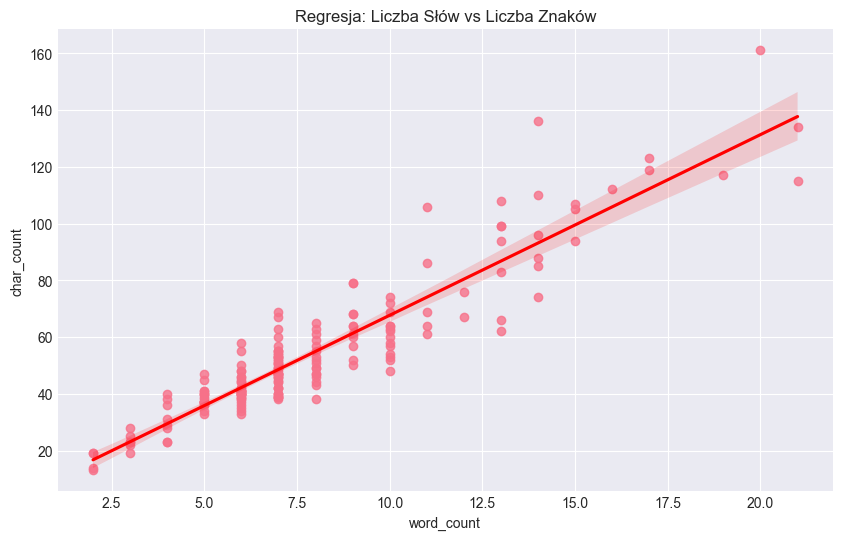

In [31]:
X = df['word_count']
Y = df['char_count']
X_const = sm.add_constant(X) # Dodajemy stałą (intercept)

model = sm.OLS(Y, X_const).fit()

print(model.summary())

plt.figure(figsize=(10, 6))
sns.regplot(x='word_count', y='char_count', data=df, line_kws={'color':'red'})
plt.title('Regresja: Liczba Słów vs Liczba Znaków')
plt.show()